#  Урок 10. Распознавание лиц и эмоций 

## Домашнее задание

(упрощенное/для тех, у кого нет вебкамеры)

1. Нужно написать приложение, которое будет получать на вход изображение.
2. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
3. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.



(более сложное)

1. Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры.
2. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
3. Человек показывает жесты руками, а алгоритм должен считать их и классифицировать.


1. Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
2. Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab
У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

## Подключение библиотек

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
PATH = '/content/gdrive/MyDrive/'
PATH_L10 = PATH + 'gb_pytorch/'
DATA_PATH = PATH + 'gb_pytorch/leapGestRecog/'

In [40]:
import os
from zipfile import ZipFile
from PIL import Image
import numpy as np
import pandas as pd
import seaborn
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch
from torch import optim
from torch.nn import functional as F

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

from sklearn.model_selection import train_test_split

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Загрузка и подготовка данных

In [6]:
os.listdir(DATA_PATH)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']

In [7]:
sorted(os.listdir(DATA_PATH + '00'))

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [8]:
os.listdir(DATA_PATH + '07/01_palm/')[:7]

['frame_07_01_0001.png',
 'frame_07_01_0002.png',
 'frame_07_01_0003.png',
 'frame_07_01_0004.png',
 'frame_07_01_0005.png',
 'frame_07_01_0006.png',
 'frame_07_01_0007.png']


Можно заметить, что нумерация файлов связана с директриями. Можно смешать их  и получить лейблы из названия.

In [9]:
skip_preparations = False

In [10]:
GESTURE_PATHS = sorted(os.listdir(DATA_PATH + '00'))
GESTURE_LABELS = {g[:2]:g[3:] for g in GESTURE_PATHS}
GESTURE_LABELS

{'01': 'palm',
 '02': 'l',
 '03': 'fist',
 '04': 'fist_moved',
 '05': 'thumb',
 '06': 'index',
 '07': 'ok',
 '08': 'palm_moved',
 '09': 'c',
 '10': 'down'}

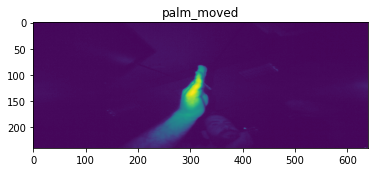

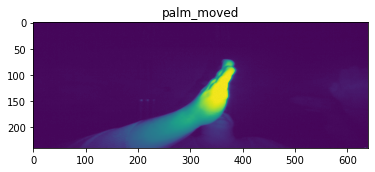

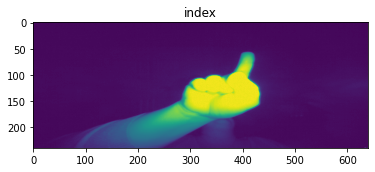

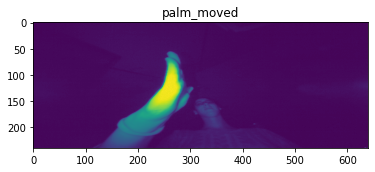

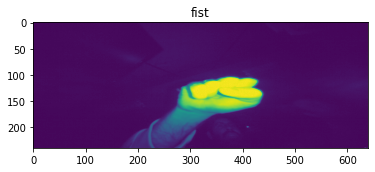

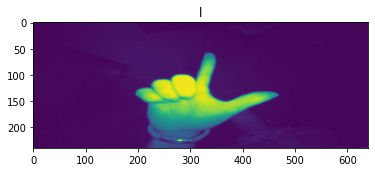

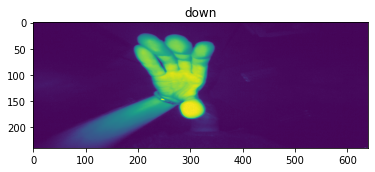

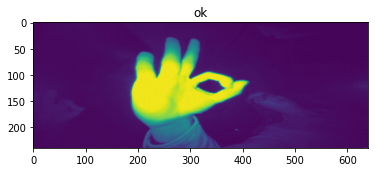

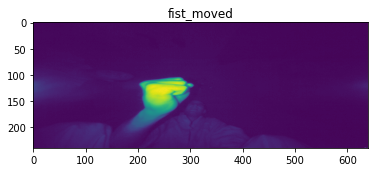

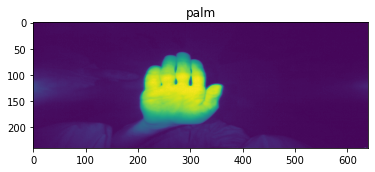

In [11]:
if not skip_preparations:
  for i in range(10):
    actor = np.random.randint(0, 10)
    gesture = np.random.randint(0, 10)
    direct_path = DATA_PATH + f'0{actor}/' + f'{GESTURE_PATHS[gesture]}/'
    im_names = os.listdir(direct_path)
    image_n = np.random.randint(0, len(im_names))
    image = Image.open(direct_path + im_names[image_n])
    plt.imshow(image)
    plt.title(f'{GESTURE_PATHS[gesture]}'[3:])
    plt.show()

In [12]:
if not skip_preparations:
  for actor in range(10):
    print(actor)
    for gesture in range(10):
        direct_path = DATA_PATH + f'0{actor}/' + f'{GESTURE_PATHS[gesture]}/'
        print(direct_path, ' : ', len(os.listdir(direct_path)))

0
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/01_palm/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/02_l/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/03_fist/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/04_fist_moved/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/05_thumb/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/06_index/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/07_ok/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/08_palm_moved/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/09_c/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/00/10_down/  :  200
1
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/01/01_palm/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/01/02_l/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/01/03_fist/  :  200
/content/gdrive/MyDrive/gb_pytorch/leapGestRecog/01/04_fist_moved/  :  200
/content/gdrive/MyDri

Можно увидеть, что в каждой папке по 200 картинок. Для удобства сохраним пути к ним в отдельном файле.

In [13]:
if not skip_preparations:
  paths = []
  for actor in range(10):
    for gesture in range(10):
        direct_path = DATA_PATH + f'0{actor}/' + f'{GESTURE_PATHS[gesture]}/'
        im_names = os.listdir(direct_path)
        for im_name in im_names:
          paths.append(direct_path + im_name)
  paths[42]

In [14]:
if not skip_preparations:
  data_info = pd.DataFrame({'paths': paths})
  data_info['label'] = data_info.paths.str[-11:-9].astype(int) - 1
  data_info.tail()

In [15]:
if not skip_preparations:
  data_info.to_csv(PATH_L10 + 'data_info.csv')

Загрузим пути к файлам из полученного csv

In [16]:
data_info = pd.read_csv(PATH_L10 + 'data_info.csv', index_col=0)
data_info

,paths,label
0,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,0
1,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,0
2,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,0
3,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,0
4,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,0
...,...,...
19995,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,9
19996,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,9
19997,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,9
19998,/content/gdrive/MyDrive/gb_pytorch/leapGestRec...,9


Преобразуем одно изображение

In [17]:
index = 42

image = Image.open(data_info.loc[index, 'paths'])
print(type(image))
print(image.size)

image = image.resize((64, 64))
print(image.size)

image = np.asarray(image).astype('float')
print(type(image))
print(image.shape)
print(image[42][42:])

image = torch.as_tensor(image)/255
print(type(image))
print(image.shape)
print(image[42][42:])

image = image.unsqueeze(0)
print(type(image))
print(image.shape)
print(image[0][42][42:])

<class 'PIL.PngImagePlugin.PngImageFile'>
(640, 240)
(64, 64)
<class 'numpy.ndarray'>
(64, 64)
[249. 249. 249. 246. 233. 218. 128.  36.  32.  25.  16.  11.  11.  11.
  10.  10.  10.  11.  12.  11.  11.  11.]
<class 'torch.Tensor'>
torch.Size([64, 64])
tensor([0.9765, 0.9765, 0.9765, 0.9647, 0.9137, 0.8549, 0.5020, 0.1412, 0.1255,
        0.0980, 0.0627, 0.0431, 0.0431, 0.0431, 0.0392, 0.0392, 0.0392, 0.0431,
        0.0471, 0.0431, 0.0431, 0.0431], dtype=torch.float64)
<class 'torch.Tensor'>
torch.Size([1, 64, 64])
tensor([0.9765, 0.9765, 0.9765, 0.9647, 0.9137, 0.8549, 0.5020, 0.1412, 0.1255,
        0.0980, 0.0627, 0.0431, 0.0431, 0.0431, 0.0392, 0.0392, 0.0392, 0.0431,
        0.0471, 0.0431, 0.0431, 0.0431], dtype=torch.float64)


                l


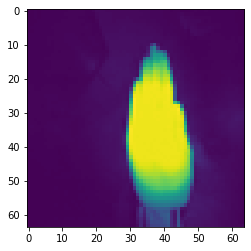

In [18]:
def output_im_show(output_im, label):
  label_str = (f'0{label + 1}', '10')[int(label == 10)]
  print(' '*15, GESTURE_LABELS[label_str])
  plt.imshow(output_im.squeeze(0).numpy())

output_im_show(image, 1)

Обернём наши данные в Dataset

In [19]:
class CustomDatasetFromImages(Dataset):
    
    def __init__(self, data_info: pd.DataFrame, preprocessing=None):
      self.data = data_info.reset_index(drop=True)
      self.data_len = self.data.shape[0]     
      self.preprocessing = preprocessing

    def __getitem__(self, index):
      image = Image.open(self.data.loc[index, 'paths'])
      label = self.data.loc[index, 'label']

      image = image.resize((64,64))
      image = np.asarray(image).astype('float')

      if self.preprocessing:
        image = self.preprocessing(image)
      image = torch.as_tensor(image)/255
      image = image.unsqueeze(0)
      return (image.float(), label)

    def __len__(self):
        return self.data_len

In [20]:
data = CustomDatasetFromImages(data_info)

Разобьём данные на тренировочную и тестовую выборки

In [21]:
X_train, X_test = train_test_split(data_info, test_size=0.25)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

Обернём данные в DataLoader

In [22]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

## Построение и обучение нейронной сети

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
net = Net().to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Функция для расчёта метрик

In [26]:
def metrics(_net, _t_loader, label):
  counter_pos = 0
  counter_tot = 0
  for i, data in enumerate(_t_loader, 0):
    inputs, labels = data[0], data[1]
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = _net(inputs)
    for j in range(len(labels)):
      counter_tot += 1
      counter_pos += int(outputs[j].argmax() == labels[j])
  result = np.floor(counter_pos/counter_tot*100)/10
  print(f'На датасете {label} правильно предсказано {result} из 10')
  return result

def metrics_train_test(_net, _train_loader, _test_loader):
  return metrics(_net=_net, _t_loader=_train_loader, label='train'), metrics(_net=_net, _t_loader=_test_loader, label='test')

Функция для обучения нейронной сети

In [27]:
def learning(net, _train_loader, _optimizer,  _criterion):
  for epoch in range(10):  # 10 эпох 
    running_loss = 0.0 
    for i, data in enumerate(_train_loader, 0):
        inputs, labels = data[0], data[1]
        inputs, labels = inputs.to(device), labels.to(device)
        # Обнуляем градиент
        _optimizer.zero_grad()
    
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс
        loss = _criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # Выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 200 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    torch.save(net.state_dict(), PATH_L10 + f'net_e10_{epoch}.pth')
  print('Training is finished!')
  return net

In [28]:
%%time
net = learning(net, train_loader, optimizer,  criterion)
torch.save(net.state_dict(), PATH_L10 + 'net_e10_2nd.pth') # cохранение обученной модели в файл

[1,     1] loss: 0.012
[1,   201] loss: 2.304
[1,   401] loss: 2.302
[1,   601] loss: 2.302
[1,   801] loss: 2.300
[2,     1] loss: 0.011
[2,   201] loss: 2.297
[2,   401] loss: 2.292
[2,   601] loss: 2.277
[2,   801] loss: 2.185
[3,     1] loss: 0.006
[3,   201] loss: 1.015
[3,   401] loss: 0.652
[3,   601] loss: 0.440
[3,   801] loss: 0.292
[4,     1] loss: 0.001
[4,   201] loss: 0.197
[4,   401] loss: 0.116
[4,   601] loss: 0.099
[4,   801] loss: 0.123
[5,     1] loss: 0.000
[5,   201] loss: 0.068
[5,   401] loss: 0.049
[5,   601] loss: 0.058
[5,   801] loss: 0.037
[6,     1] loss: 0.000
[6,   201] loss: 0.031
[6,   401] loss: 0.044
[6,   601] loss: 0.024
[6,   801] loss: 0.028
[7,     1] loss: 0.000
[7,   201] loss: 0.018
[7,   401] loss: 0.010
[7,   601] loss: 0.010
[7,   801] loss: 0.013
[8,     1] loss: 0.000
[8,   201] loss: 0.011
[8,   401] loss: 0.009
[8,   601] loss: 0.009
[8,   801] loss: 0.010
[9,     1] loss: 0.000
[9,   201] loss: 0.003
[9,   401] loss: 0.010
[9,   601] 

In [29]:
%%time
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

На датасете train правильно предсказано 9.9 из 10
На датасете test правильно предсказано 9.9 из 10
CPU times: user 58.8 s, sys: 3.99 s, total: 1min 2s
Wall time: 20min 15s


Построим confusion matrix

Text(0.5, 68.09375, 'Predicted label')

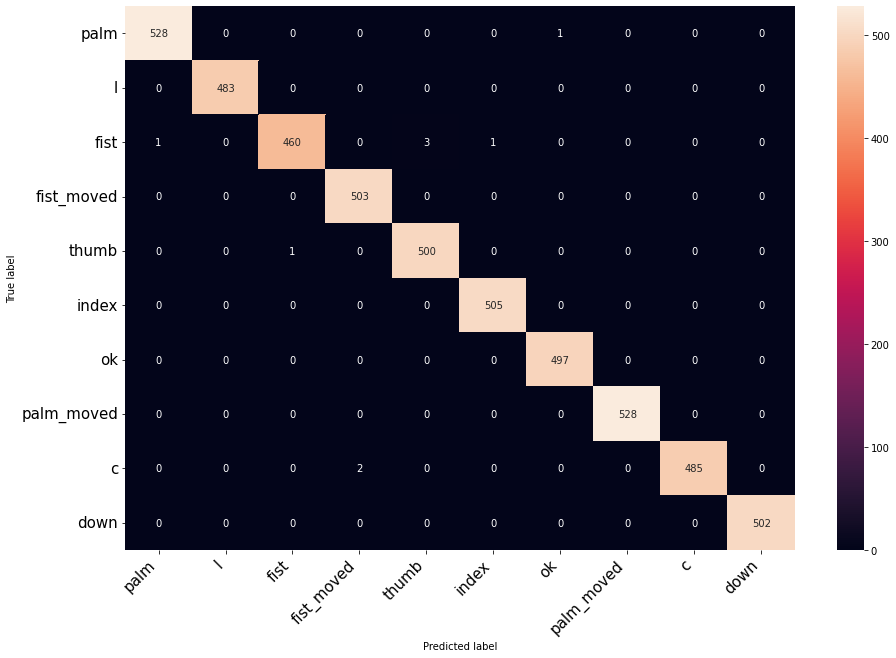

In [31]:
confusion_matrix = torch.zeros(10, 10)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        for j in range(outputs.shape[0]):
          guessed_label = outputs[j].argmax().item()
          truth_label = labels[j]
          confusion_matrix[guessed_label, truth_label] += 1

plt.figure(figsize=(15,10))

class_names = [v for v in GESTURE_LABELS.values()]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [32]:
net_loaded = Net().to(device)

Загрузим сохраненную модель

In [33]:
net_loaded.load_state_dict(torch.load(PATH_L10 + 'net_e10_2nd.pth'))

<All keys matched successfully>

Text(0.5, 68.09375, 'Predicted label')

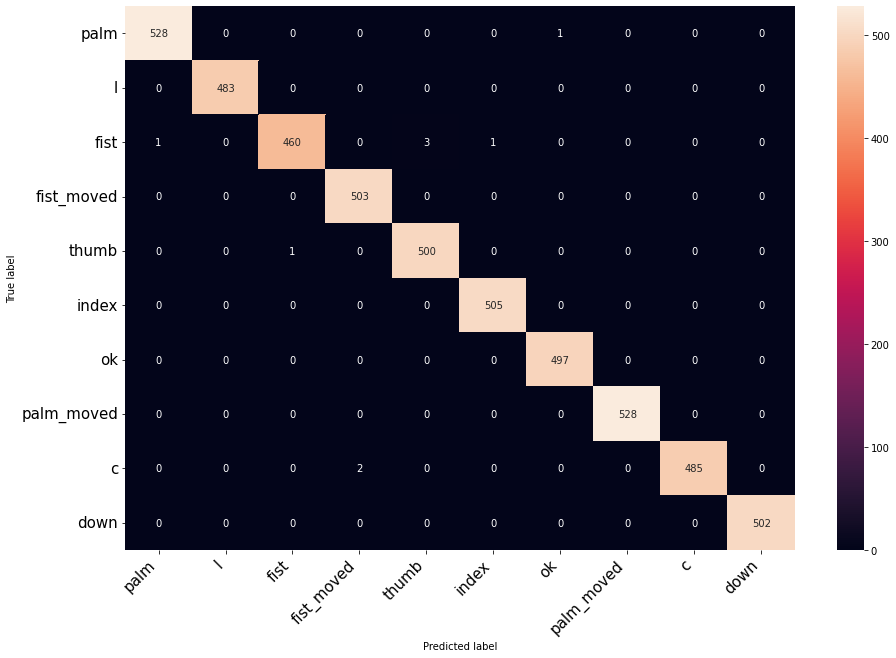

In [34]:
confusion_matrix = torch.zeros(10, 10)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net_loaded(images)
        for j in range(outputs.shape[0]):
          guessed_label = outputs[j].argmax().item()
          truth_label = labels[j]
          confusion_matrix[guessed_label, truth_label] += 1

plt.figure(figsize=(15,10))

class_names = [v for v in GESTURE_LABELS.values()]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = seaborn.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


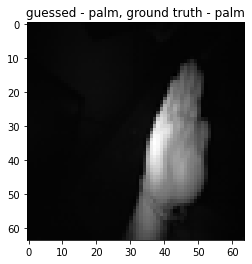

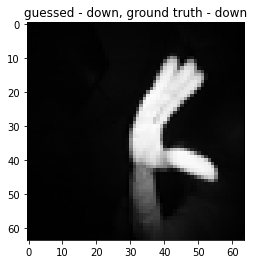

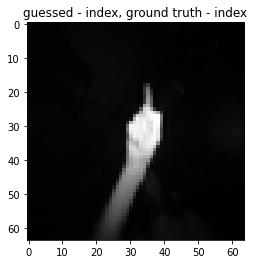

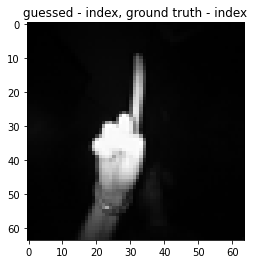

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


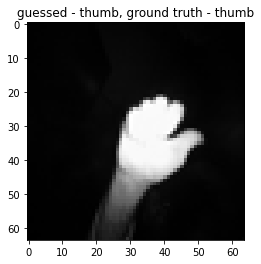

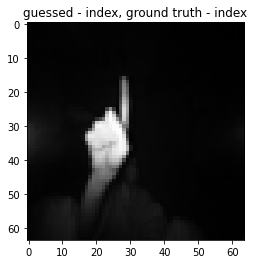

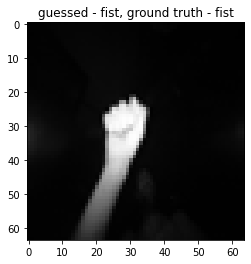

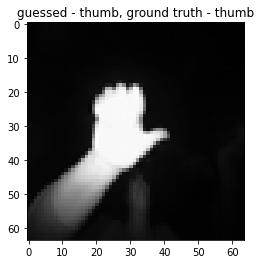

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


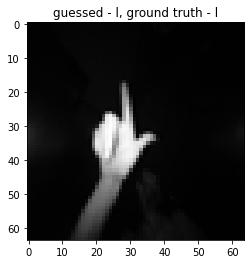

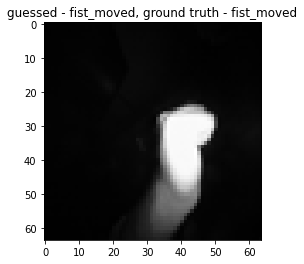

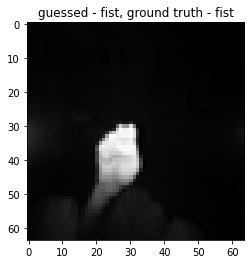

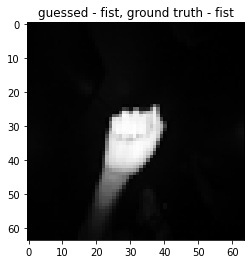

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


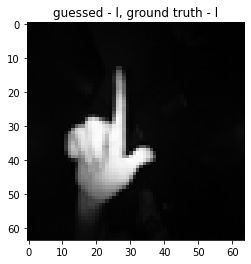

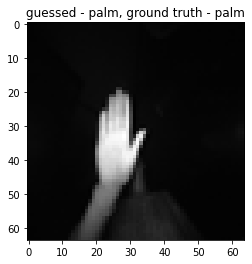

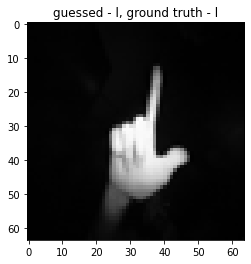

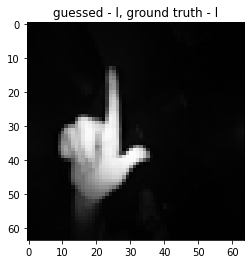

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


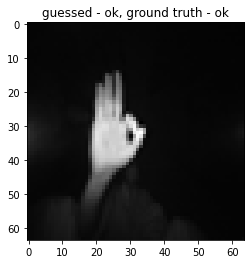

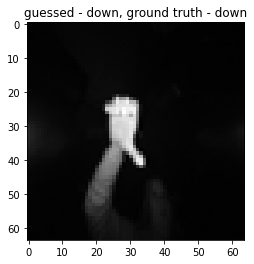

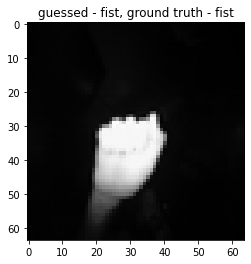

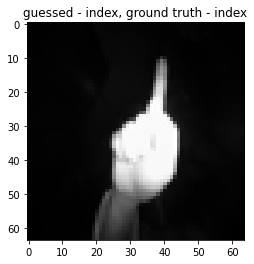

torch.Size([4, 1, 64, 64])
torch.Size([4, 10])


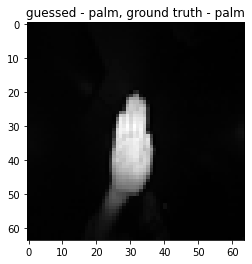

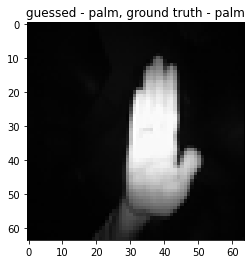

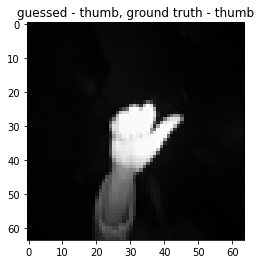

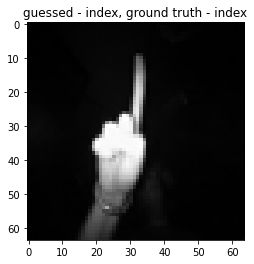

In [35]:
with torch.no_grad():
  for i, data in enumerate(test_loader):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = net_loaded(images)
      print(images.shape)
      print(outputs.shape)
      for j in range(outputs.shape[0]):
        guessed_label = outputs[j].argmax().item()
        guessed_label =  GESTURE_LABELS[(f'0{guessed_label + 1}', '10')[int(guessed_label == 9)]]
        truth_label = labels[j]
        truth_label =  GESTURE_LABELS[(f'0{truth_label + 1}', '10')[int(truth_label == 9)]]
        plt.title(f'guessed - {guessed_label}, ground truth - {truth_label}')
        plt.imshow(images[j].cpu().squeeze(), cmap='gray')
        plt.show()
      if i>4:
          break